# Download the trajectories

In [1]:
!pip install gdown
!gdown --id --no-cookies 1IfX0dHDn2dfhljIClfK3vGyJWp56pZJz


import pickle

with open('trajectories_with_timestamps.pkl', 'rb') as f:
    trajectories_with_timestamps = pickle.load(f)

!rm /kaggle/working/trajectories_with_timestamps.pkl

  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - \ | done
  Preparing metadata (pyproject.toml) ... - \ | done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14775 sha256=c965834b57c293a7c2e6fd95efd4246a36104c8afe0d52c4f7e15e4f5d852a53
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1IfX0dHDn2dfhljIClfK3vGyJWp56pZJz
To: /kaggle/working/trajectories_with_timestamps.pkl
100%|███████████████████████████████████████| 28.7M/28.7M [00:00<00:00, 121MB/s]


In [2]:
import threading
import subprocess
import zipfile
from time import sleep
from multiprocessing import Pool
from functools import partial
from os import listdir, remove, devnull, makedirs, rmdir
from os.path import join, isfile


def download_part(part):
    archive_path = f'/kaggle/bdd_{part:02d}.zip'
    # Dowload the zip archive
    subprocess.check_output([
        'curl',
        '-Lo',
        archive_path,
        f'http://dl.yf.io/bdd100k/video_parts/bdd100k_videos_train_{part:02d}.zip'
    ])

    # unzip 
    with zipfile.ZipFile(archive_path, 'r') as f:
        f.extractall('/kaggle')
    # Delete the archive
    remove(archive_path)


def extract_frames(frames_path, videos_path, video_name):
    name = video_name[:-4]
    output_path = f'{frames_path}/{name}'
    makedirs(output_path)
    info_file_name = f'{name}.json' 
    try:
        timestamps = trajectories_with_timestamps[info_file_name]
    except KeyError:
        # This means the video isn't in our processing limits `50 <= displacement <= 2500`.
        rmdir(output_path)
    else:
        with open(devnull, 'w') as f:
            for idx, timestamp in enumerate(timestamps):
                subprocess.check_call(['ffmpeg',
                                       '-hide_banner',
                                       '-loglevel',
                                       'error',
                                       '-ss',
                                        timestamp,
                                        '-i',
                                        f'{videos_path}/{video_name}',
                                        '-frames:v',
                                        '1',
                                        '-q:v',
                                        '2',
                                        '-vf',
                                        'scale=400:-1:flags=lanczos',
                                        f'{output_path}/{idx:03d}.png'
                                        ], stdout=f)
    finally:
        # remove the video after processing it.
        remove(f'{videos_path}/{video_name}')


processed_videos = set()
pool = Pool(processes=4)

def process_videos():
    frames_path = '/kaggle/working/frames'
    videos_path = '/kaggle/bdd100k/videos/train'
    videos_names = [f for f in
                    listdir(videos_path) 
                    if isfile(join(videos_path, f)) and f not in processed_videos
                    ]
    processed_videos.update(videos_names)
    pool.map(partial(extract_frames, frames_path, videos_path), videos_names)
    
def download_then_process(parts):
    threads = []
    for part in parts:
        download_part(part)
        thread = threading.Thread(target=process_videos)
        thread.start()
        threads.append(thread)
    return threads

def block_until_processing_is_done(processing_threads):
    for thread in processing_threads:
        thread.join()

# Process videos

## Reset output directory

In [3]:
# def reset_output_dir():
#     !rm -rf $frames_path && mkdir $frames_path
#     return
# reset_output_dir()

## Processing

In [4]:
processing_threads = download_then_process([0, 1])
block_until_processing_is_done(processing_threads)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.4G  100 18.4G    0     0  8893k      0  0:36:13  0:36:13 --:--:-- 9998k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.4G  100 18.4G    0     0  8442k      0  0:38:11  0:38:11 --:--:-- 8627k


In [5]:
from random import choice
from os import listdir

from IPython.display import Image, FileLink


def make_gif_from_frames(frames_path, output_path, *,loop=-1, fps=10):
    subprocess.check_call(['ffmpeg',
                           '-y',
                           '-hide_banner',
                           '-loglevel',
                           'error',
                           '-f',
                           'image2',
                           '-framerate',
                           str(fps),
                           '-pattern_type',
                           'glob',
                           '-i',
                           f"{frames_path}/*.png",
                           '-loop',
                           str(loop),
                           output_path
                        ])
    return Image(open(output_path, 'rb').read())    

def get_random_processed_video_name():
    return choice(listdir('/kaggle/working/frames'))

In [6]:
name = get_random_processed_video_name()

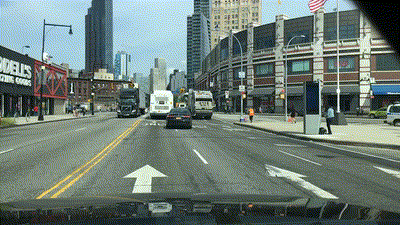

In [7]:
output_path = f'{name}.gif'
make_gif_from_frames(f'/kaggle/working/frames/{name}', output_path, loop=1, fps=5)

In [8]:
FileLink(f'{name}.gif')

/kaggle/working/0233c21b-577418b6.gif

In [9]:
! ls /kaggle/working/frames | wc -l

1453
